# StreetBee: SU detection 
### by AIvanov


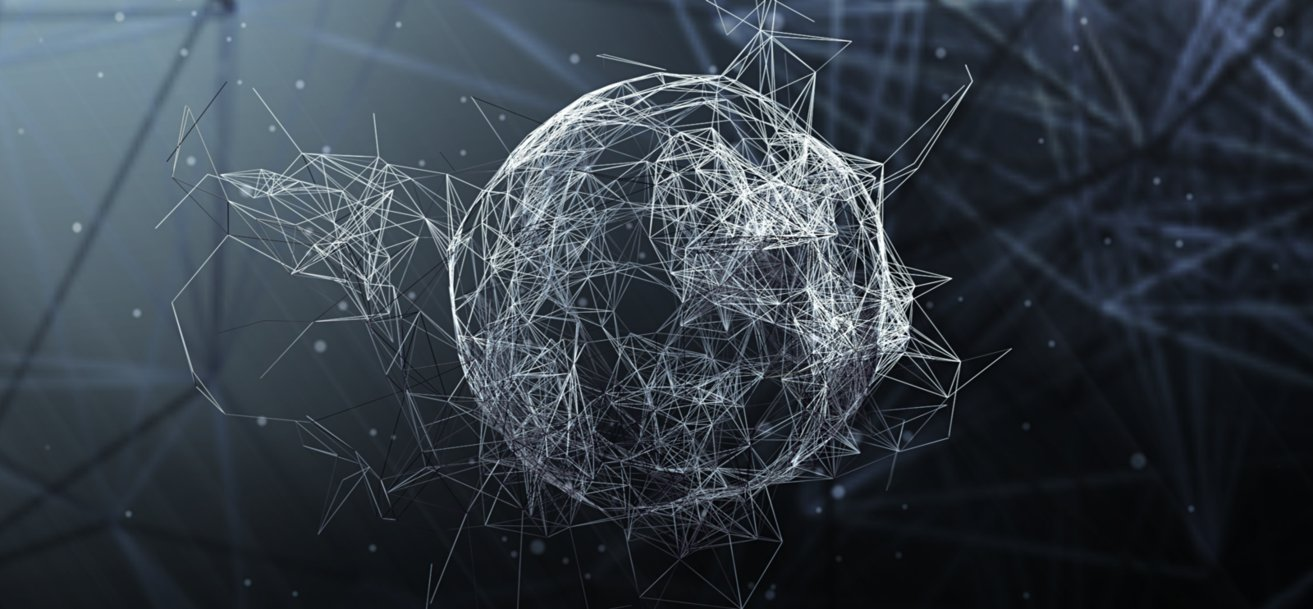

In [1]:
import os
from IPython.display import Image
logo = Image(filename=os.path.join('.', 'logo.jpg'))
display(logo)

In [2]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import copy
from glob import glob
import torchvision.models as models
from torch.utils.data import Dataset
import cv2
from PIL import Image
import random
import torchvision.transforms
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from torchvision import transforms

%matplotlib inline

In [3]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
cv2.setRNGSeed(seed)

In [4]:
debug = False

In [5]:
from dataloaders import TestDataset

In [6]:
test_set_name = 'test'
train_set_path = os.path.join('.', test_set_name)

In [7]:
test_data = TestDataset(train_set_path)

In [8]:
test_len = len(test_data)
test_len

9

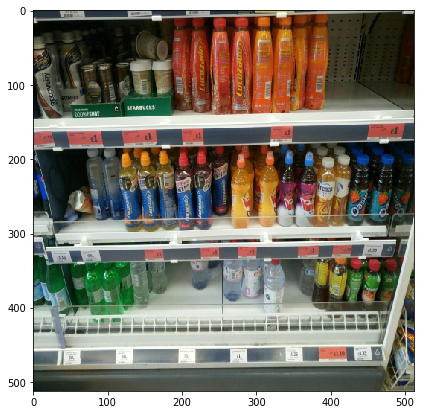

In [9]:
# Example images
for i in range(0, int(test_len * 0.01 + 1)):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(test_data[i].cpu().numpy().transpose(1, 2, 0))

### Load segmentation network and run test inference

In [10]:
from bisenet import *

### Parameters

In [11]:
B_SIZE = 4# Set desired batch size
class_number = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Data loader

In [12]:
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=B_SIZE, 
                                           shuffle=True)

### Segmentation network

In [13]:
model_dir = os.path.join('.', 'model')
if (not os.path.exists(model_dir)):
    os.mkdir(model_dir)
model_st_path = os.path.join('.', model_dir, 'state_bisenet_rs18.pth')
model_path = os.path.join('.', model_dir, 'bisenet_rs18.pth')
model = None

In [14]:
model = torch.load(model_path)
model.load_state_dict(torch.load(model_st_path))
model.eval()

BiSeNet(
  (context_path): ResNetEncoder(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNo

In [15]:
for inputs in test_loader:
    print(len(inputs))
    break

4


In [16]:
model.eval()
outputs = model(inputs.to(device, dtype=torch.float))

In [17]:
from bisenet_training import scale_to_output

In [18]:
predictions = outputs[0]
predictions = scale_to_output(predictions, (8 , 8))

### Index of item to visualize

In [29]:
current_item = 2

In [30]:

print(inputs.shape)

sample_input = inputs[current_item].cpu().numpy()
sample_input = sample_input.transpose(1, 2, 0)
print(sample_input.shape)

sample_output = predictions[current_item].detach().cpu().numpy()
print(sample_output.shape)

background_mask = sample_output[0]
foreground_mask = sample_output[1]
final_mask = foreground_mask

torch.Size([4, 3, 512, 512])
(512, 512, 3)
(2, 512, 512)


### Visualize mask

In [32]:
from visutils import draw_mask

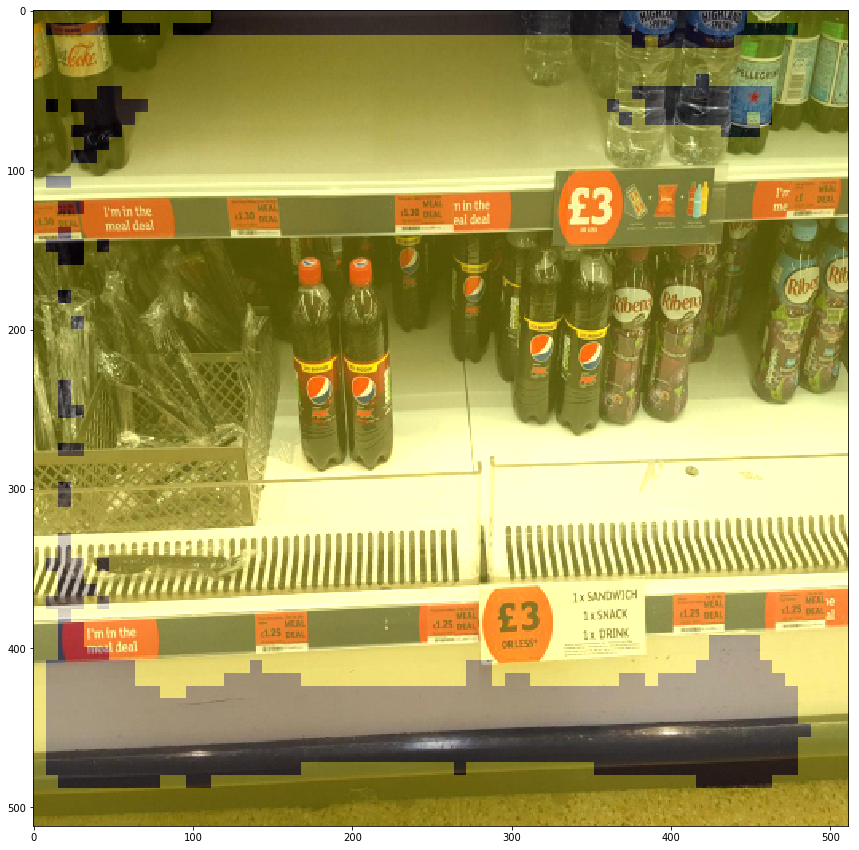

In [37]:
threshold = 70 # threshold for segmentation mask
dst = draw_mask(sample_input, final_mask, threshold)
fig=plt.figure(figsize=(15, 15))
plt.imshow(dst)

In [34]:
from visutils import full_norm

In [38]:
final_mask = full_norm(final_mask)
final_mask.min()

ret, a = cv2.threshold(final_mask.astype(np.uint8), threshold, 255, cv2.THRESH_BINARY)
a = np.expand_dims(a, axis = 2)
thresh_mask = a.astype(np.uint8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


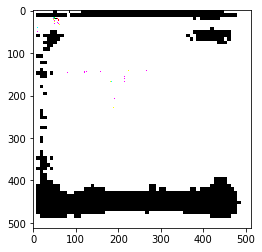

In [39]:
final_ouput = cv2.bitwise_and(sample_input, sample_input, mask=thresh_mask)
plt.imshow(final_ouput)